In [1]:
import numpy as np 
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
from linear_sca import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV, LinearRegression, RidgeCV

In [2]:
path = "/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy"

X = np.load(path).swapaxes(1,2)
print(X.shape)
K, N, T = X.shape

X, _ = pre_processing(X)

(108, 182, 140)


In [3]:
U, ls_loss, ls_S_ratio = optimize(X,d=4) 

Iteration 0, S: 5.751235676143551e-06, S_ratio: 0.24984584748744965
Iteration 10, S: -4.933548098051688e-06, S_ratio: -0.15320567786693573
Iteration 20, S: 7.3076371336355805e-06, S_ratio: 0.284526526927948
Iteration 30, S: 1.016789519781014e-05, S_ratio: 0.3901345431804657
Iteration 40, S: 1.0048600415757392e-05, S_ratio: 0.8509909510612488
Iteration 50, S: 9.26553002500441e-06, S_ratio: 0.42003485560417175
Iteration 60, S: 1.554432742523204e-06, S_ratio: 0.1326962411403656
Iteration 70, S: -1.1229435585846659e-05, S_ratio: -0.3811076879501343
Iteration 80, S: 9.649173080106266e-06, S_ratio: 1.21725332736969
Iteration 90, S: 2.008669798669871e-05, S_ratio: 0.8510453701019287
Iteration 100, S: 1.8626593373483047e-05, S_ratio: 0.4531513750553131
Iteration 110, S: 4.019964762846939e-05, S_ratio: 0.5665876865386963
Iteration 120, S: 7.839242243790068e-06, S_ratio: 0.20542722940444946
Iteration 130, S: 1.668684672040399e-05, S_ratio: 0.3247675895690918
Iteration 140, S: 1.9427836377872154e

In [4]:
np.save('U_psth_0.001_10000_4d', U)

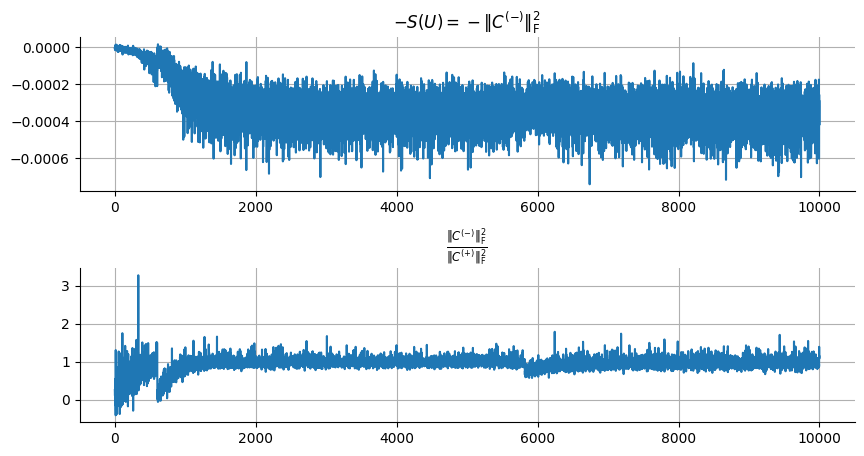

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

In [21]:
U = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/SCA_project/U_psth_0.001_10000_6d.npy')

Text(0.5, 0.92, 'sca 0.46')

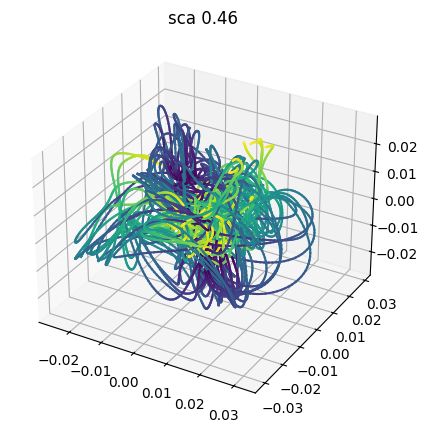

In [23]:
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X)
#idx = [0,2]
plot_3D(Y[:,:,:])
plt.title(f"sca {var_explained(X, U_qr):.2f}")

Text(0.5, 0.92, 'pca 0.45')

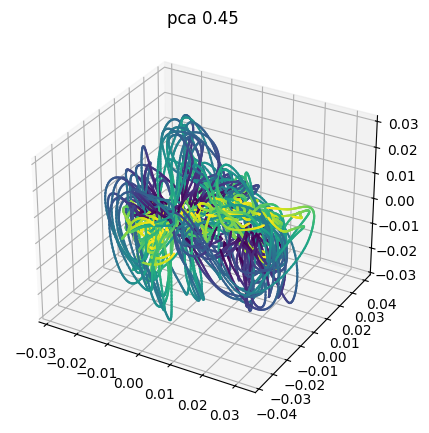

In [25]:
""" PCA """
split = 10
X_reshaped = np.concatenate(X.swapaxes(1,2))

num_pcs = 4
pca = PCA(num_pcs)
X_pca = pca.fit_transform(X_reshaped)
PCs = pca.components_
X_pca = X_pca.reshape(K, T, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_3D(X_pca)
plt.title(f"pca {var_explained(X, PCs.T):.2f}")

In [10]:
hand_vel = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_eval_behaviour_grouped.npy").swapaxes(1,2)

In [11]:
def get_reg(X_train,y_train,X_test, y_test):
    regr = RidgeCV()
    reg = regr.fit(X_train, y_train)   
    return reg.score(X_test, y_test)   

In [24]:
split = 10
lag = 20
X_train = np.concatenate(Y[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(Y[:split,:,:-lag].swapaxes(1,2))

y_train = np.concatenate(hand_vel[split:,:,lag:].swapaxes(1,2))
y_test = np.concatenate(hand_vel[:split,:,lag:].swapaxes(1,2))

get_reg(X_train,y_train,X_test, y_test)

0.6513052669545053

In [26]:
X_train = np.concatenate(X_pca[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(X_pca[:split,:,:-lag].swapaxes(1,2))

get_reg(X_train,y_train,X_test, y_test)

0.4585342945213085

In [14]:
X_train = np.concatenate(X[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(X[:split,:,:-lag].swapaxes(1,2))

get_reg(X_train,y_train,X_test, y_test)

0.7906247807807922